In this notebook we tried different models in gridsearch:
- HistGradientBoostingRegressor
- Poisson
- Linear Regression
- KNRegressor
- Random Forest
- Decision Tree

In [ ]:
# Install OSMNX only if working on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install osmnx
    !pip install matplotlib==3.1.1 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

import sklearn
import requests

In [ ]:
# Load datasets if working on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    file_id = '1tfAjKLhhl3lteqf_EkFoyIPY2IdBJFVn'
    downloaded = drive.CreateFile({'id':file_id})
    downloaded.FetchMetadata(fetch_all=True)
    downloaded.GetContentFile(downloaded.metadata['title'])
    f = open("V2data_6mounts2022.csv.zip", "wb")
    f.write(downloaded.content.getbuffer())
    f.close()
    !unzip V2data_6mounts2022.csv.zip

In [ ]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    r = requests.get('https://raw.githubusercontent.com/dominik117/data-science-toolkit/main/helper_notebooks/data_processor.py')
    with open('data_processor.py', 'w') as f:
        f.write(r.text)
    r = requests.get('https://raw.githubusercontent.com/dominik117/data-science-toolkit/main/helper_notebooks/darkzone_creator.py')
    with open('darkzone_creator.py', 'w') as f:
        f.write(r.text)

import data_processor 
import darkzone_creator

In [ ]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB: df_main_url = '/content/data.csv'
else: df_main_url = '../../../Information/output/datav2.csv'
amenities_df = pd.read_csv(df_main_url, dtype = {'place.id': object})
amenities_df.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')
amenities_df = data_processor.clean_df(amenities_df)
amenities_df = data_processor.aggregate_df(amenities_df)
amenities_df['row_type'] = "ground truth"
amenities_df = data_processor.make_date_features(amenities_df)
amenities_df = data_processor.make_coordinates_features(amenities_df)
amenities_df = data_processor.make_edge_length_feature(amenities_df)
amenities_df = data_processor.make_weather_features(amenities_df)
amenities_df, osm_columns = data_processor.make_osm_features(amenities_df)

In [1]:
amenities_df.info()

NameError: ignored

In [ ]:
cat_features_lst = ['date_utc', 'edge_id', 'edge_osmid', 'osm_highway', 
                              'month', 'day', 'weekday', 'holiday', 'atm', 'bar', 
                              'bench', 'childcare', 'cinema', 'clinic', 'fast_food', 
                              'fountain', 'fuel', 'ice_cream', 'kindergarten', 
                              'marketplace', 'nightclub', 'parking', 'recycling', 
                              'school', 'taxi', 'toilets', 'vending_machine', 
                              'waste_basket', 'waste_disposal']

In [ ]:
num_features_lst = ['lat_north', 'lat_south', 'lon_east', 'lon_west', 
                          'edge_length', 'temperature_max', 'temperature_min', 
                          'temperature_mean', 'precipitation', 'snowfall', 
                          'humidity_max', 'humidity_min', 'humidity_mean', 
                          'cloud_coverage', 'wind_speed_max', 'wind_speed_min', 
                          'wind_speed_mean']

In [ ]:
df_log = pd.DataFrame(columns = ['model', 'features', 'litter', 'score'])

# HistGradientBoostingRegressor

In [ ]:
def grid_for_hist_gb_regressor(lit, df):
  # Splitting
  X_train, X_test, y_train, y_test = train_test_split(df.drop(df.iloc[:, 4:36], axis = 1), df[lit], test_size=0.2)
  # Categorical & numeric
  all_categorical_features = cat_features_lst
  all_numeric_features = num_features_lst
  categorical_features = X_train[[i for i in X_train.columns if i in all_categorical_features]].columns.tolist()
  numeric_features = X_train[[i for i in X_train.columns if i in all_numeric_features]].columns.tolist()
  #Categorical and numeric transformer
  categorical_transformer = Pipeline(steps=[("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan))])
  #Preprocessor
  preprocessor = ColumnTransformer(transformers=[("num", "passthrough",
                                                       numeric_features),
                                                 ("cat", categorical_transformer,
                                                       categorical_features)]
                                   )
  #Model
  hgb_poisson_model = HistGradientBoostingRegressor(learning_rate=0.01)

  hgb_pipeline_poisson = Pipeline(steps=[
                              ("pre_process", preprocessor),
                              ("hgb_poisson_model", hgb_poisson_model)
                              ])
  
  grid_search = {'hgb_poisson_model__loss': ["poisson"], 
                 'hgb_poisson_model__learning_rate': [2e-2],
                 'hgb_poisson_model__max_iter':[1000, 10000], 
                 'hgb_poisson_model__l2_regularization':[2e-2]
               }
               
  print(hgb_poisson_model.get_params(), '\n')
  print(hgb_pipeline_poisson.get_params().keys(), '\n')
  print(sorted(sklearn.metrics.SCORERS.keys()))

  model = GridSearchCV(estimator=hgb_pipeline_poisson, param_grid=grid_search,
                     scoring='neg_mean_poisson_deviance', verbose=5, n_jobs=-1)
  
  model.fit(X_train, y_train)

  # prediction = model.best_estimator_.predict(X_test)

  best_model = model.best_estimator_

  score = best_model.score(X_test, y_test)

  cols = list(X_test.columns)
  model = best_model[1]
  print(cols)
  print(model)
  print('\n')
  return score, cols, model


### Model

In [ ]:
lit = 'total_litter'
score, cols, model = grid_for_hist_gb_regressor(lit, amenities_df)
df_log = df_log.append({'model':model, 'features': cols, 'litter':lit, 'score': score}, ignore_index=True)
print(f'hgb with poisson score for total litter: {score}')

{'categorical_features': None, 'early_stopping': 'auto', 'l2_regularization': 0.0, 'learning_rate': 0.01, 'loss': 'squared_error', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 

dict_keys(['memory', 'steps', 'verbose', 'pre_process', 'hgb_poisson_model', 'pre_process__n_jobs', 'pre_process__remainder', 'pre_process__sparse_threshold', 'pre_process__transformer_weights', 'pre_process__transformers', 'pre_process__verbose', 'pre_process__verbose_feature_names_out', 'pre_process__num', 'pre_process__cat', 'pre_process__cat__memory', 'pre_process__cat__steps', 'pre_process__cat__verbose', 'pre_process__cat__ordinal', 'pre_process__cat__ordinal__categories', 'pre_process__cat__ordinal__dtype', 'pre_process__cat__ordinal__handle_unknown', 'pre_process__cat__ordinal__unknown_va

In [ ]:
df_log

,model,features,litter,score
0,HistGradientBoostingRegressor(l2_regularizatio...,"[date_utc, edge_id, edge_osmid, osm_highway, m...",total_litter,0.5283


# Poisson

In [ ]:
def grid_for_poisson(lit, df):
  # Splitting
  X_train, X_test, y_train, y_test = train_test_split(df.drop(df.iloc[:, 4:36], axis = 1), df[lit], test_size=0.2)
  # Categorical & numeric
  all_categorical_features = cat_features_lst 
  all_numeric_features = num_features_lst
  categorical_features = X_train[[i for i in X_train.columns if i in all_categorical_features]].columns.tolist()
  numeric_features = X_train[[i for i in X_train.columns if i in all_numeric_features]].columns.tolist()
  #Categorical and numeric transformer
  categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])
  numeric_transformer = Pipeline(steps=[("scaler", RobustScaler())])
  #Preprocessor
  preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer,
                                                       numeric_features),
                                                 ("cat", categorical_transformer,
                                                       categorical_features)]
                                   )
  #Model
  poisson_model = PoissonRegressor()

  pipeline_poisson = Pipeline(steps=[
                              ("pre_process", preprocessor),
                              ("poisson_model", poisson_model)
                              ])
  
  print(poisson_model.get_params(), '\n')
  print(pipeline_poisson.get_params().keys(), '\n')
  print(sorted(sklearn.metrics.SCORERS.keys()))
  
  grid_search = {'poisson_model__alpha' : [1e-4],
                 'poisson_model__max_iter' : [10000]
                 }

  model = GridSearchCV(estimator=pipeline_poisson, param_grid=grid_search,
                     scoring='neg_mean_poisson_deviance', verbose=5, n_jobs=-1)
  model.fit(X_train, y_train)

  # prediction = model.best_estimator_.predict(X_test)

  best_model = model.best_estimator_

  score = best_model.score(X_test, y_test)

  cols = list(X_test.columns)
  model = best_model[1]
  print(cols)
  print(model)
  print('\n')
  return score, cols, model


In [ ]:
lit = 'total_litter'
score, cols, model = grid_for_poisson(lit, amenities_df)
df_log = df_log.append({'model':model, 'features': cols, 'litter':lit, 'score': score}, ignore_index=True)
print(f'poisson score for total litter: {score}')

{'alpha': 1.0, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 

dict_keys(['memory', 'steps', 'verbose', 'pre_process', 'poisson_model', 'pre_process__n_jobs', 'pre_process__remainder', 'pre_process__sparse_threshold', 'pre_process__transformer_weights', 'pre_process__transformers', 'pre_process__verbose', 'pre_process__verbose_feature_names_out', 'pre_process__num', 'pre_process__cat', 'pre_process__num__memory', 'pre_process__num__steps', 'pre_process__num__verbose', 'pre_process__num__scaler', 'pre_process__num__scaler__copy', 'pre_process__num__scaler__quantile_range', 'pre_process__num__scaler__unit_variance', 'pre_process__num__scaler__with_centering', 'pre_process__num__scaler__with_scaling', 'pre_process__cat__memory', 'pre_process__cat__steps', 'pre_process__cat__verbose', 'pre_process__cat__onehot', 'pre_process__cat__onehot__categories', 'pre_process__cat__onehot__drop', 'pre_process__cat__onehot__dtype', 'pre_process__cat__onehot__

In [ ]:
df_log

,model,features,litter,score
0,HistGradientBoostingRegressor(l2_regularizatio...,"[date_utc, edge_id, edge_osmid, osm_highway, m...",total_litter,0.528300
1,"PoissonRegressor(alpha=0.0001, max_iter=10000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",total_litter,0.642749


# Linear Regression

In [ ]:
def grid_for_linear_reg(lit, df):
  # Splitting
  X_train, X_test, y_train, y_test = train_test_split(df.drop(df.iloc[:, 4:36], axis = 1), df[lit], test_size=0.2)
  # Categorical & numeric
  all_categorical_features = cat_features_lst 
  all_numeric_features = num_features_lst
  categorical_features = X_train[[i for i in X_train.columns if i in all_categorical_features]].columns.tolist()
  numeric_features = X_train[[i for i in X_train.columns if i in all_numeric_features]].columns.tolist()
  #Categorical and numeric transformer
  categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])
  numeric_transformer = Pipeline(steps=[("scaler", RobustScaler())])
  #Preprocessor
  preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer,
                                                       numeric_features),
                                                 ("cat", categorical_transformer,
                                                       categorical_features)]
                                   )
  #Model
  lr_model = linear_model.LinearRegression()

  pipeline_lr = Pipeline(steps=[
                              ("pre_process", preprocessor),
                              ("lr_model", lr_model)
                              ])
  
  grid_search = {} 

  model = GridSearchCV(estimator=pipeline_lr, param_grid=grid_search,
                     scoring='r2', verbose=5, n_jobs=-1)
  model.fit(X_train, y_train)

  # prediction = model.best_estimator_.predict(X_test)

  best_model = model.best_estimator_

  score = best_model.score(X_test, y_test)

  cols = list(X_test.columns)
  model = best_model[1]
  print(cols)
  print(model)
  print('\n')
  return score, cols, model


In [ ]:
lit = 'total_litter'
score, cols, model = grid_for_linear_reg(lit, amenities_df)
df_log = df_log.append({'model':model, 'features': cols, 'litter':lit, 'score': score}, ignore_index=True)
print(f'Linear regression score for total litter: {score}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
['date_utc', 'edge_id', 'edge_osmid', 'osm_highway', 'month', 'day', 'weekday', 'holiday', 'lat_north', 'lat_south', 'lon_east', 'lon_west', 'edge_length', 'temperature_max', 'temperature_min', 'temperature_mean', 'precipitation', 'snowfall', 'humidity_max', 'humidity_min', 'humidity_mean', 'cloud_coverage', 'wind_speed_max', 'wind_speed_min', 'wind_speed_mean', 'atm', 'bar', 'bench', 'childcare', 'cinema', 'clinic', 'fast_food', 'fountain', 'fuel', 'ice_cream', 'kindergarten', 'marketplace', 'nightclub', 'parking', 'recycling', 'school', 'taxi', 'toilets', 'vending_machine', 'waste_basket', 'waste_disposal']
LinearRegression()


Linear regression score for total litter: 0.28441413568139273


In [ ]:
df_log

,model,features,litter,score
0,HistGradientBoostingRegressor(l2_regularizatio...,"[date_utc, edge_id, edge_osmid, osm_highway, m...",total_litter,0.528300
1,"PoissonRegressor(alpha=0.0001, max_iter=10000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",total_litter,0.642749
2,LinearRegression(),"[date_utc, edge_id, edge_osmid, osm_highway, m...",total_litter,0.284414


In [ ]:
df_log.to_csv('models_score.csv')

# KNRegressor

In [ ]:
def grid_for_knn(lit, df):
  # Splitting
  X_train, X_test, y_train, y_test = train_test_split(df.drop(df.iloc[:, 4:36], axis = 1), df[lit], test_size=0.2)
  # Categorical & numeric
  all_categorical_features = cat_features_lst 
  all_numeric_features = num_features_lst
  categorical_features = X_train[[i for i in X_train.columns if i in all_categorical_features]].columns.tolist()
  numeric_features = X_train[[i for i in X_train.columns if i in all_numeric_features]].columns.tolist()
  #Categorical and numeric transformer
  categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])
  numeric_transformer = Pipeline(steps=[("scaler", RobustScaler())])
  #Preprocessor
  preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer,
                                                       numeric_features),
                                               ("cat", categorical_transformer,
                                                       categorical_features)])
  #Model
  knn_model = KNeighborsRegressor()

  pipeline_knn = Pipeline(steps=[
                              ("pre_process", preprocessor),
                              ("knn_model", knn_model)
                              ])
  
  grid_search = {'knn_model__n_neighbors': [5, 10], 'knn_model__weights': ['uniform']
               }

  model = GridSearchCV(estimator=pipeline_knn, param_grid=grid_search,
                     scoring='r2', verbose=5, n_jobs=-1)
  model.fit(X_train,y_train)

  #prediction = model.best_estimator_.predict(X_test)

  best_model = model.best_estimator_

  score = best_model.score(X_test, y_test)

  cols = list(X_test.columns)
  model = best_model[1]
  print(cols)
  print(model)
  print('\n')
  return score, cols, model


In [ ]:
lit = 'total_litter'
score, cols, model = grid_for_knn(lit, amenities_df)
df_log = df_log.append({'model':model, 'features': cols, 'litter':lit, 'score': score}, ignore_index=True)
print(f'kn-regressor score for total litter: {score}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


['date_utc', 'edge_id', 'edge_osmid', 'osm_highway', 'month', 'day', 'weekday', 'holiday', 'lat_north', 'lat_south', 'lon_east', 'lon_west', 'edge_length', 'temperature_max', 'temperature_min', 'temperature_mean', 'precipitation', 'snowfall', 'humidity_max', 'humidity_min', 'humidity_mean', 'cloud_coverage', 'wind_speed_max', 'wind_speed_min', 'wind_speed_mean', 'atm', 'bar', 'bench', 'childcare', 'cinema', 'clinic', 'fast_food', 'fountain', 'fuel', 'ice_cream', 'kindergarten', 'marketplace', 'nightclub', 'parking', 'recycling', 'school', 'taxi', 'toilets', 'vending_machine', 'waste_basket', 'waste_disposal']
KNeighborsRegressor(n_neighbors=10)


kn-regressor score for total litter: 0.25401767057844604


In [ ]:
df_log

,model,features,litter,score
0,HistGradientBoostingRegressor(l2_regularizatio...,"[date_utc, edge_id, edge_osmid, osm_highway, m...",total_litter,0.528300
1,"PoissonRegressor(alpha=0.0001, max_iter=10000)","[date_utc, edge_id, edge_osmid, osm_highway, m...",total_litter,0.642749
2,LinearRegression(),"[date_utc, edge_id, edge_osmid, osm_highway, m...",total_litter,0.284414
3,KNeighborsRegressor(n_neighbors=10),"[date_utc, edge_id, edge_osmid, osm_highway, m...",total_litter,0.254018


# Random Forest

In [ ]:
def grid_for_random_forest(lit, df):
  # Splitting
  X_train, X_test, y_train, y_test = train_test_split(df.drop(df.iloc[:, 4:36], axis = 1), df[lit], test_size=0.2)
  # Categorical & numeric
  all_categorical_features = cat_features_lst 
  all_numeric_features = num_features_lst
  categorical_features = X_train[[i for i in X_train.columns if i in all_categorical_features]].columns.tolist()
  numeric_features = X_train[[i for i in X_train.columns if i in all_numeric_features]].columns.tolist()
  #Categorical transformer
  categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])
  #Preprocessor
  preprocessor = ColumnTransformer(transformers=[("num", "passthrough",
                                                       numeric_features),
                                               ("cat", categorical_transformer,
                                                       categorical_features)])
  #Model
  rfr_model =  RandomForestRegressor()

  pipeline_rfr = Pipeline(steps=[("pre_process", preprocessor), 
                               ("rfr_model", rfr_model)
                              ])
  
  print(pipeline_rfr.get_params().keys())
  
  grid_search = {'rfr_model__n_estimators': [100],
                 'rfr_model__max_depth': [100], #10, 500, None
                 'rfr_model__criterion': ['poisson'],
               }
               
  model = GridSearchCV(estimator=pipeline_rfr, param_grid=grid_search,
                     scoring='r2', verbose=5, n_jobs=-1)
  model.fit(X_train, y_train)

  # predictionforest = model.best_estimator_.predict(X_test)

  best_model = model.best_estimator_

  score = best_model.score(X_test, y_test)

  cols = list(X_test.columns)
  model = best_model[1]
  print(cols)
  print(model)
  print('\n')
  return score, cols, model


In [ ]:
lit = 'total_litter'
score, cols, model = grid_for_random_forest(lit, amenities_df)
df_log = df_log.append({'model':model, 'features': cols, 'litter':lit, 'score': score}, ignore_index=True)
print(f'Random Forest score for total litter: {score}')

In [ ]:
df_log

# Decision Tree

In [ ]:
def grid_for_decision_tree(lit, df):
  # Splitting
  X_train, X_test, y_train, y_test = train_test_split(df.drop(df.iloc[:, 4:36], axis = 1), df[lit], test_size=0.2)
  # Categorical & numeric
  all_categorical_features = cat_features_lst 
  all_numeric_features = num_features_lst
  categorical_features = X_train[[i for i in X_train.columns if i in all_categorical_features]].columns.tolist()
  numeric_features = X_train[[i for i in X_train.columns if i in all_numeric_features]].columns.tolist()
  #Categorical transformer
  categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])
  #Preprocessor
  preprocessor = ColumnTransformer(transformers=[("num", "passthrough",
                                                       numeric_features),
                                                 ("cat", categorical_transformer,
                                                       categorical_features)]
                                   )
  #Model
  dtr_model =  DecisionTreeRegressor()

  pipeline_dtr = Pipeline(steps=[("pre_process", preprocessor), 
                                 ("dtr_model", dtr_model)
                              ])
  grid_search = {'dtr_model__n_estimators': [100],
                 'dtr_model__max_depth': [10, 100], #10, 500
                 'dtr_model__criterion': ['poisson'],
               }
               
  model = GridSearchCV(estimator=pipeline_dtr, param_grid=grid_search,
                     scoring='r2', verbose=5, n_jobs=-1)
  model.fit(X_train, y_train)

  # predictionforest = model.best_estimator_.predict(X_test)

  best_model = model.best_estimator_

  score = best_model.score(X_test, y_test)

  cols = list(X_test.columns)
  model = best_model[1]
  print(cols)
  print(model)
  print('\n')
  return score, cols, model

In [ ]:
lit = 'total_litter'
score, cols, model = grid_for_decision_tree(lit, amenities_df)
df_log = df_log.append({'model':model, 'features': cols, 'litter':lit, 'score': score}, ignore_index=True)
print(f'Decision Tree score for total litter: {score}')

In [ ]:
df_log

In [ ]:
df_log.to_csv('models_score6.csv')
from google.colab import files
files.download('models_score6.csv') 

# Model scores

In [ ]:
df_log = df_log.sort_values(by='score')

In [ ]:
df_log['name'] = df_log['model'].apply(lambda x: x[:x.find('Regress')]+'Regression')

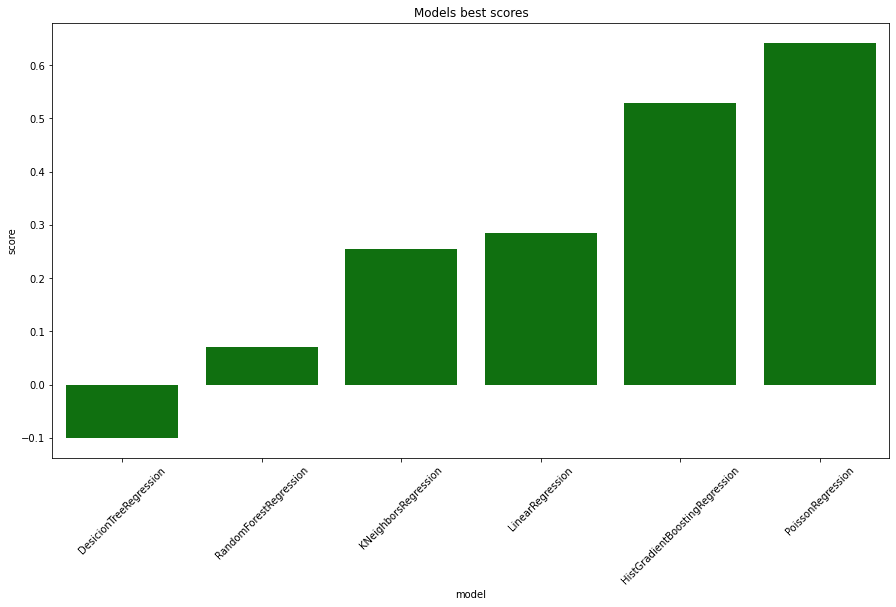

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=df_log, x = 'name', y='score', ax=ax, color='green')
ax.set_title("Models best scores")
ax.set_xlabel("model")
plt.xticks(rotation = 45)
ax.set_ylabel("score");
fig.show()
fig.savefig('Models_scores.pdf');